# Lab 6

### <span style="color:chocolate"> Submission requirements </span>

Additional points may be deducted if these requirements are not met:
    
* Comment your code
* Each graph should have a title, labels for each axis, and (if needed) a legend. Each graph should be understandable on its own
* Be sure your submitted notebook includes the output of your run (Hint: go to Kernel -> Restart Kernel and Run All Cells...)
* Try and minimize the use of the global namespace (meaning, keep things inside functions)
* Upload your .ipynb file to Gradescope when done
---

This lab connects all the pieces involved in training feed-forward fully connected neural networks. You will run a full set of experiments to explore different hyperparameters and hidden layer sizes for both the MNIST and FASHION_MNIST datasets, and report your findings.

In [9]:
# Import the libraries we'll use below.
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
from tabulate import tabulate
sns.set(style="darkgrid")  # default style

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.utils import to_categorical
from keras import metrics
tf.get_logger().setLevel('INFO')

## Datasets


### Fashion MNIST

We load the fashion_mnist dataset as before.

Label: t-shirt


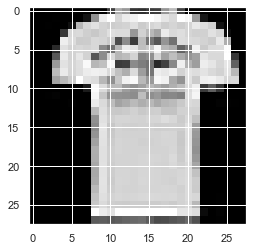

In [10]:
from keras.datasets import fashion_mnist

# Load the Fashion MNIST dataset.
(X_train_fashion, Y_train_fashion), (X_test_fashion, Y_test_fashion) = fashion_mnist.load_data()
X_train_fashion = X_train_fashion / 255.##pixel values ranging from 0-255
X_test_fashion = X_test_fashion / 255.

# Flatten Y_train and Y_test, so they become vectors of label values.
Y_train_fashion = Y_train_fashion.flatten()
Y_test_fashion = Y_test_fashion.flatten()

label_names = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
               'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

# Apply random shufflying to training examples.
np.random.seed(0)
indices = np.arange(X_train_fashion.shape[0])
shuffled_indices = np.random.permutation(indices)
X_train_fashion = X_train_fashion[shuffled_indices]
Y_train_fashion = Y_train_fashion[shuffled_indices]

# Show the first training example.
print('Label: %s' %label_names[Y_train_fashion[0]])
plt.imshow(X_train_fashion[0], cmap='gray')
plt.show()

In [11]:
#shape of the images 
print("shape:", X_train_fashion[0].shape)
print()
print("First image:\n", X_train_fashion[0])

shape: (28, 28)

First image:
 [[0.         0.         0.00392157 0.         0.         0.00784314
  0.         0.         0.         0.         0.25490196 0.67058824
  0.59607843 0.20784314 0.18431373 0.23137255 0.24313725 0.58823529
  0.72941176 0.25882353 0.         0.         0.         0.
  0.00392157 0.00392157 0.         0.        ]
 [0.         0.         0.         0.00392157 0.         0.
  0.         0.0745098  0.57254902 0.9254902  0.99607843 0.84313725
  0.9254902  0.94901961 1.         1.         0.96470588 0.90196078
  0.85098039 1.         0.96862745 0.60392157 0.09019608 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.00392157 0.         0.         0.0627451
  0.71764706 0.83921569 0.88235294 0.82745098 0.80392157 0.81568627
  0.82745098 0.8745098  0.8        0.83529412 0.85882353 0.80392157
  0.83529412 0.80392157 0.83529412 0.90980392 0.87058824 0.82352941
  0.07058824 0.         0.         0.        ]
 [0.         0.         0.         0.

### MNIST

We also load the (digits) mnist dataset in the same way. Note that the number of train/test examples as well as the data shapes are identical to fashion_mnist.

Label: 3


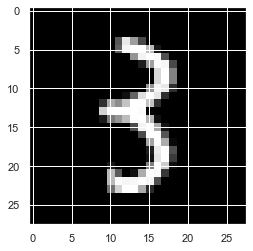

In [12]:
from keras.datasets import mnist

# Load the MNIST dataset.
(X_train_digits, Y_train_digits), (X_test_digits, Y_test_digits) = mnist.load_data()
X_train_digits = X_train_digits / 255
X_test_digits = X_test_digits / 255

# Flatten Y_train and Y_test, so they become vectors of label values.
Y_train_digits = Y_train_digits.flatten()
Y_test_digits = Y_test_digits.flatten()

# Apply random shufflying to training examples.
np.random.seed(0)
indices = np.arange(X_train_digits.shape[0])
shuffled_indices = np.random.permutation(indices)
X_train_digits = X_train_digits[shuffled_indices]
Y_train_digits = Y_train_digits[shuffled_indices]

# Show the first training example.
print('Label: %d' %Y_train_digits[0])
plt.imshow(X_train_digits[0], cmap='gray')
plt.show()

In [13]:
# Shape of the images and the first image

print("Shape:", X_train_digits[0].shape)
print()
print("First image:\n", X_train_digits[0])

Shape: (28, 28)

First image:
 [[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.

## Build a Model

We will write a build_model function that allows for a range of experiments on both datasets.

---
### Exercise 1 (50 points)

Fill in code that implements the build_model function, including all the arguments listed in the function definition [Note: the activation function parameter is only for the the hidden layers, use the appropriate final classification function for the final layer as usual].

In [14]:
#version 4: Oct 5 2023
def build_model(n_classes,
                hidden_layer_sizes=[],
                activation='relu',
                optimizer='SGD',
                learning_rate=0.01):
    """Build a multi-class or binary classification model using Keras.

    Args:
        n_classes: Number of output classes in the dataset.
        hidden_layer_sizes: A list with the number of units in each hidden layer.
        activation: The activation function to use for the hidden layers.
        optimizer: The optimizer to use (SGD, Adam).
        learning_rate: The desired learning rate for the optimizer.

    Returns:
        model: A tf.keras model (graph).
    """
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)
    
    # YOUR CODE HERE

    # Create a Sequential model
    model = keras.Sequential()

    # Add a Flatten layer (if needed)
    # Keras layers can do pre-processing. This layer will take our 28x28 images
    model.add(keras.layers.Flatten())

        # Add hidden layers based on the hidden_layer_sizes list
    for units in hidden_layer_sizes:
        model.add(keras.layers.Dense(units=units, activation=activation))

    # Add the output layer
    model.add(keras.layers.Dense(units=n_classes, activation='softmax'))
        
    # Define the optimizer based on the input argument
    if optimizer == 'SGD':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == 'Adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise ValueError("Unsupported optimizer. Please use 'SGD' or 'Adam'.")

    # Compile the model with the selected optimizer and appropriate loss
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model


---

## Run Experiments

We can now run a suite of experiments to see how the hyperparameters and layer sizes effect performance. The train_and_evaluate function below can be used to run experiments and retrieve results.

Training...


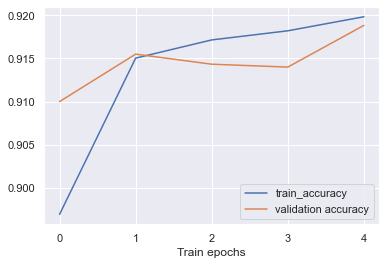

Test Accuracy: 0.9207


In [15]:
def train_and_evaluate(data='digits',
                       hidden_layer_sizes=[],
                       activation='tanh',
                       optimizer='Adam',
                       learning_rate=0.01,
                       num_epochs=5):

  # Build the model.
  model = build_model(n_classes=10,
                      hidden_layer_sizes=hidden_layer_sizes,
                      activation=activation,
                      optimizer=optimizer,
                      learning_rate=learning_rate)

  # Select the dataset.
  if data == 'digits':
    X_train = X_train_digits
    X_test = X_test_digits
    Y_train = Y_train_digits
    Y_test = Y_test_digits
    Y_train = Y_train_digits
    
  elif data == 'fashion':
    
    X_train = X_train_fashion
    X_test = X_test_fashion
    Y_train = Y_train_fashion
    Y_test = Y_test_fashion
    
  else:
    raise 'Unsupported dataset: %s' %data

  # Train the model.
  print('Training...')
  history = model.fit(
    x=X_train,
    y=Y_train,
    epochs=num_epochs,
    batch_size=64,
    validation_split=0.1,
    verbose=0)

  # Retrieve the training metrics (after each train epoch) and the final test
  # accuracy.
  train_accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  plt.plot(train_accuracy, label='train_accuracy')
  plt.plot(val_accuracy, label='validation accuracy')
  plt.xticks(range(num_epochs))
  plt.xlabel('Train epochs')
  plt.legend()
  plt.show()

  test_accuracy = model.evaluate(x=X_test, y=Y_test, verbose=0,
                                 return_dict=True)['accuracy']
  return test_accuracy

print('Test Accuracy: %1.4f' %train_and_evaluate())

---
### Exercise 2 (50 points)

Run experiments and fill in the test results in the table below. Feel free to extend the table to more experiments as you see fit.

#### Student Solution

DATA | HIDDEN SIZES | ACTIVATION | OPTIMIZER | LEARNING RATE | #PARAMETERS | TEST ACCURACY
-|-|-|-|-|-|-
digits|[]|tanh|SGD|0.01|7850|0.8966
digits|[]|relu|SGD|0.01|7850|0.8966
digits|[]|relu|Adam|0.01|7850|0.9207
digits|[128]|relu|Adam|0.01|101770|0.9683
digits|[256,128]|relu|Adam|0.01|235146|0.9632
-
fashion|[]|tanh|SGD|0.01|7850|0.8092
fashion|[]|relu|SGD|0.01|7850|0.8092
fashion|[]|relu|Adam|0.01|7850|0.8356
fashion|[128]|relu|Adam|0.01|101770|0.8551
fashion|[256,128]|relu|Adam|0.01|235146|0.8535


Training...


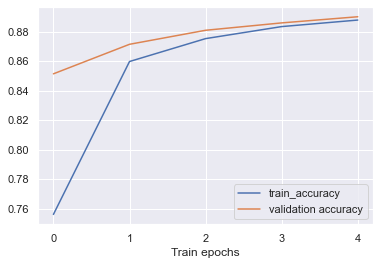

Training...


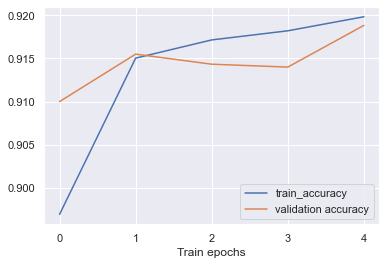

Training...


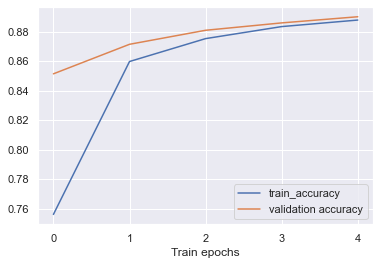

Training...


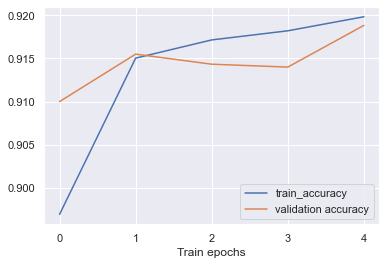

Training...


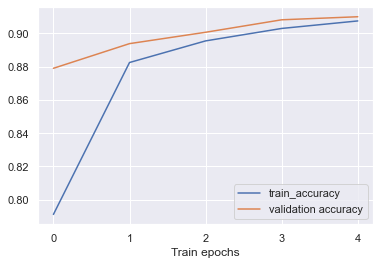

Training...


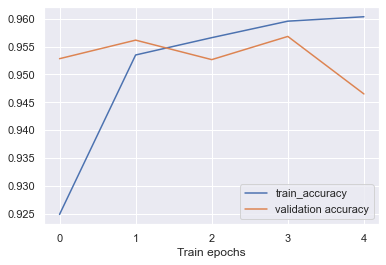

Training...


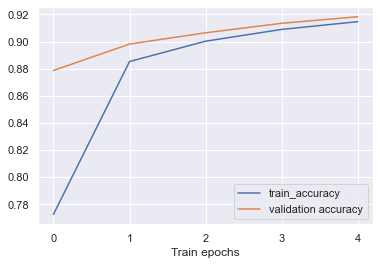

Training...


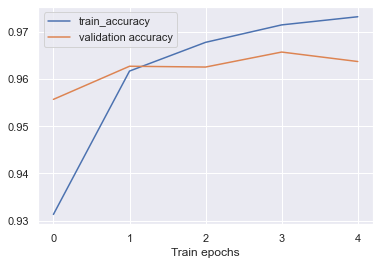

Training...


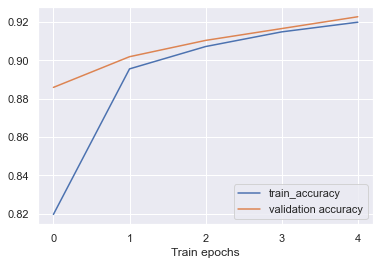

Training...


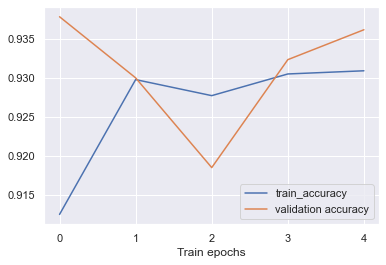

Training...


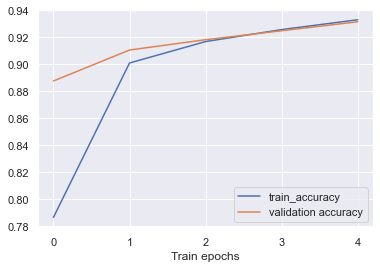

Training...


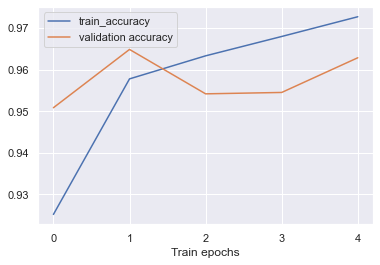

Training...


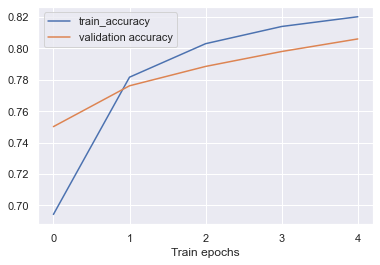

Training...


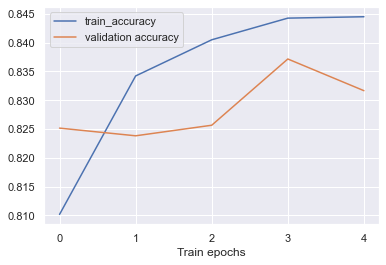

Training...


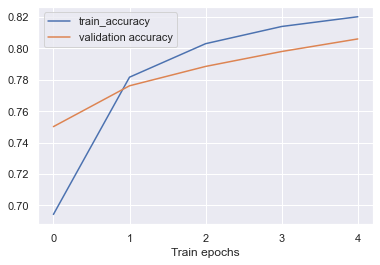

Training...


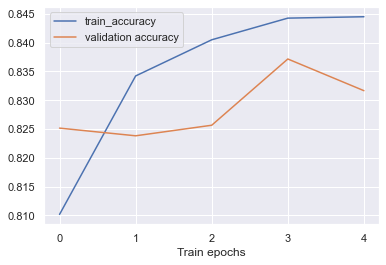

Training...


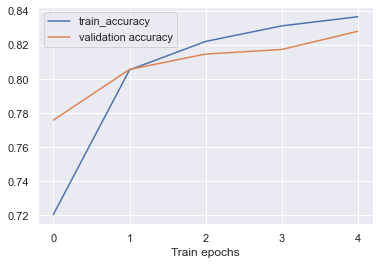

Training...


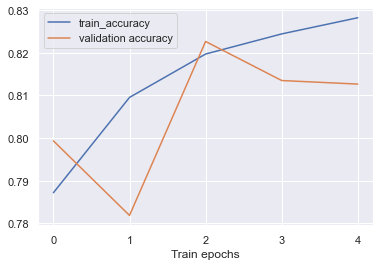

Training...


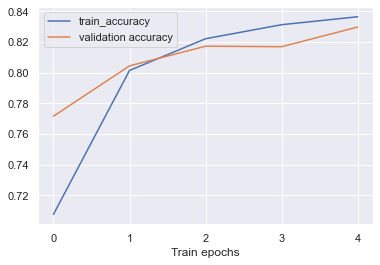

Training...


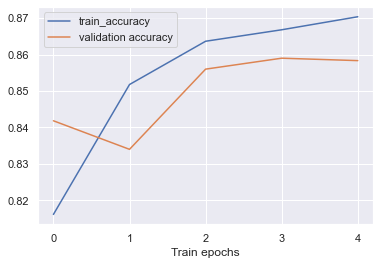

Training...


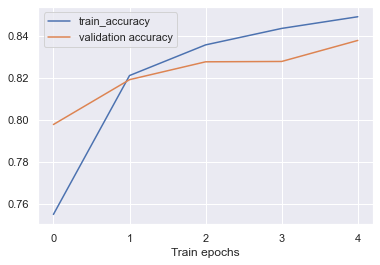

Training...


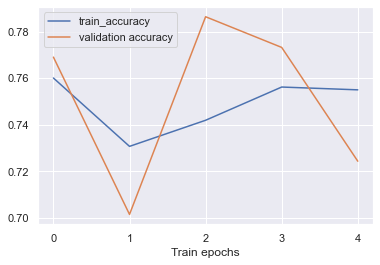

Training...


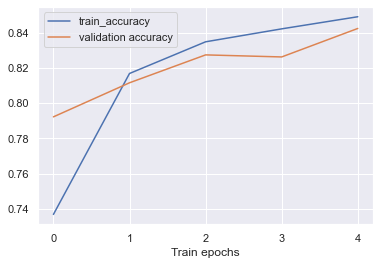

Training...


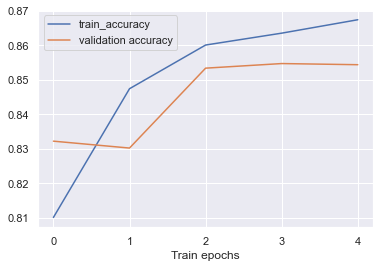

| DATA    | HIDDEN SIZES   | ACTIVATION   | OPTIMIZER   |   LEARNING RATE |   TEST ACCURACY |   #Parameters |
|:--------|:---------------|:-------------|:------------|----------------:|----------------:|--------------:|
| digits  | []             | tanh         | SGD         |            0.01 |          0.8966 |          7850 |
| digits  | []             | tanh         | Adam        |            0.01 |          0.9207 |          7850 |
| digits  | []             | relu         | SGD         |            0.01 |          0.8966 |          7850 |
| digits  | []             | relu         | Adam        |            0.01 |          0.9207 |          7850 |
| digits  | [128]          | tanh         | SGD         |            0.01 |          0.9157 |        101770 |
| digits  | [128]          | tanh         | Adam        |            0.01 |          0.95   |        101770 |
| digits  | [128]          | relu         | SGD         |            0.01 |          0.9218 |        101770 |
| digits  

In [16]:
# Define a list to store the results
results = []

# Define the hyperparameter combinations to search
datasets = ["digits", "fashion"]
hidden_layer_sizes = [[], [128], [256, 128]]
activations = ["tanh", "relu"]
optimizers = ["SGD", "Adam"]
learning_rate = 0.01
def dense_layer_params(input_shape, units_list):
    """
    Calculate the number of parameters in a list of Dense (fully connected) layers.

    Args:
        input_shape (tuple): The shape of the input data (e.g., (None, input_dim)).
        units_list (list): A list of the number of units or neurons in each Dense layer.

    Returns:
        int: The total number of parameters in all Dense layers combined.
    """
    total_params = 0
    input_dim = input_shape[-1]  # Get the last dimension of the input shape
    
    if not units_list:
        # If there are no hidden layers, calculate only input and output layer parameters
        output_classes = 10  # Replace with the actual number of output classes
        total_params = (input_dim * output_classes) + output_classes
    else:
        # Calculate parameters for hidden layers and output layer
        for units in units_list:
            total_params += (input_dim + 1) * units  # Add 1 for the bias term
            input_dim = units  # Update input_dim for the next layer
        
        # Calculate parameters for the output layer
        output_classes = 10  # Replace with the actual number of output classes
        total_params += (units_list[-1] + 1) * output_classes  # Add 1 for the bias term
    
    return total_params
# Iterate over hyperparameter combinations
for data in datasets:
    for hidden_sizes in hidden_layer_sizes:
        for activation in activations:
            for optimizer in optimizers:
                # Build and evaluate the model
                model = build_model(n_classes=10, hidden_layer_sizes=hidden_sizes, activation=activation, optimizer=optimizer, learning_rate=learning_rate)
                test_accuracy = train_and_evaluate(data, hidden_sizes, activation, optimizer, learning_rate)
                
                # Calculate the number of parameters for each hidden layer
                input_shape = (None, 784)
                num_parameters = dense_layer_params(input_shape, units_list=hidden_sizes)
                
                # Append the results to the list
                results.append([data, hidden_sizes, activation, optimizer, learning_rate, test_accuracy, num_parameters])

# Create a DataFrame to display the results
results_df = pd.DataFrame(results, columns=["DATA", "HIDDEN SIZES", "ACTIVATION", "OPTIMIZER", "LEARNING RATE",  "TEST ACCURACY","#Parameters"])

# Print the DataFrame
print(results_df.to_markdown(index=False))